# Load Dataset To Send To Server

In [1]:
import sparseml
from sparseml.pytorch.datasets import ImagenetteDataset, ImagenetteSize
from sparseml.pytorch.models import ModelRegistry

# pull model to get image size
zoo_stub_path = (
    "zoo:cv/classification/resnet_v1-50/pytorch/sparseml/imagenet/pruned_quant-moderate"
    "?recipe=transfer_learn"
)
model = ModelRegistry.create(
    key="resnet50",
    pretrained_path=zoo_stub_path,
    pretrained_dataset="imagenette",
    num_classes=10,
    ignore_error_tensors=["classifier.fc.weight", "classifier.fc.bias"],
)

input_shape = ModelRegistry.input_shape("resnet50")
input_size = input_shape[-1]

# get data
test_data = ImagenetteDataset(train=False,
                              dataset_size=ImagenetteSize.s320,
                              image_size=input_size)

already downloaded imagenette ImagenetteSize.s320


# Send Requests To The Server

Note: the server expects images to come in unnormalized form (i.e. the inference server will do the pre-processing itself, so we must send de-normalized images

In [3]:
import matplotlib.pyplot as plt

import torch
from sparseml.utils.datasets import IMAGENET_RGB_MEANS, IMAGENET_RGB_STDS

stds = torch.tensor(IMAGENET_RGB_STDS)
means = torch.tensor(IMAGENET_RGB_MEANS)

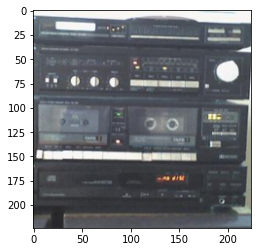

In [11]:
i = 10

plt.imshow(test_data[i][0].permute(1,2,0) * stds + means)

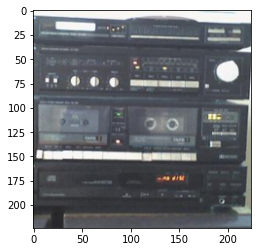

In [12]:
dl_it = iter(dl)

for _ in range(i):
    next(dl_it)
img = next(dl_it)

plt.imshow(img[0].squeeze().permute(1,2,0) * stds + means)

In [9]:
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

dl = DataLoader(test_data, 1, shuffle=False, num_workers=1)

base_path = "./images/"
true_labels = []

i = 0
for batch in tqdm(iter(dl)):
    img_path = base_path + f"img_{i}.jpg" 

    save_image((batch[0].squeeze().permute(1,2,0) * stds + means).permute(2,0,1), img_path)
    true_labels.append(batch[1])
    i+=1

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
N = len(dl)
print(N)

500


In [13]:
print((batch[0].squeeze().permute(1,2,0) * stds + means).shape)

torch.Size([224, 224, 3])


In [29]:
import requests
import json


url = 'http://0.0.0.0:5551/predict/from_files'
num_correct = 0

labels = []
for i in tqdm(range(N)):
    img_path = f'./images/img_{i}.jpg'
    files = [('request', open(img_path, 'rb'))]
    
    resp = requests.post(url=url, files =files)
    label = json.loads(resp.text)['labels'][0]
    labels.append(label)
    if label == test_data[i][1]:
        num_correct += 1

print(f'{num_correct} / {N} correct: {num_correct / N}')

  0%|          | 0/500 [00:00<?, ?it/s]

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=5551): Max retries exceeded with url: /predict/from_files (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f15d041c040>: Failed to establish a new connection: [Errno 111] Connection refused'))